### Матричные факторизации

В данной работе вам предстоит познакомиться с практической стороной матричных разложений.
Работа поделена на 4 задания:
1. Вам необходимо реализовать SVD разложения используя SGD на explicit данных
2. Вам необходимо реализовать матричное разложения используя ALS на implicit данных
3. Вам необходимо реализовать матричное разложения используя BPR на implicit данных
4. Вам необходимо реализовать матричное разложения используя WARP на implicit данных

Мягкий дедлайн 13 Октября (пишутся замечания, выставляется оценка, есть возможность исправить до жесткого дедлайна)

Жесткий дедлайн 20 Октября (Итоговая проверка)

In [1]:
import implicit
import pandas as pd
import numpy as np
import scipy.sparse as sp
import random

from lightfm.datasets import fetch_movielens

In [ ]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

В данной работе мы будем работать с explicit датасетом movieLens, в котором представленны пары user_id movie_id и rating выставленный пользователем фильму

Скачать датасет можно по ссылке https://grouplens.org/datasets/movielens/1m/

In [2]:
ratings = pd.read_csv('ml-1m/ratings.dat', delimiter='::', header=None, 
        names=['user_id', 'movie_id', 'rating', 'timestamp'], 
        usecols=['user_id', 'movie_id', 'rating'], engine='python')

In [3]:
movie_info = pd.read_csv('ml-1m/movies.dat', delimiter='::', header=None, 
        names=['movie_id', 'name', 'category'], engine='python', encoding="utf-8")

Explicit данные

In [4]:
ratings.head(10)

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
5,1,1197,3
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4


Для того, чтобы преобразовать текущий датасет в Implicit, давайте считать что позитивная оценка это оценка >=4

In [5]:
implicit_ratings = ratings.loc[(ratings['rating'] >= 4)]

In [6]:
implicit_ratings.head(10)

,user_id,movie_id,rating
0,1,1193,5
3,1,3408,4
4,1,2355,5
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4
10,1,595,5
11,1,938,4
12,1,2398,4


Удобнее работать с sparse матричками, давайте преобразуем DataFrame в CSR матрицы

In [7]:
users = implicit_ratings["user_id"]
movies = implicit_ratings["movie_id"]
user_item = sp.coo_matrix((np.ones_like(users), (users, movies)))
user_item_t_csr = user_item.T.tocsr()
user_item_csr = user_item.tocsr()

В качестве примера воспользуемся ALS разложением из библиотеки implicit

Зададим размерность латентного пространства равным 64, это же определяет размер user/item эмбедингов

In [8]:
model = implicit.als.AlternatingLeastSquares(factors=64, iterations=100, calculate_training_loss=True)

В качестве loss здесь всеми любимый RMSE

In [9]:
model.fit(user_item_t_csr)

100%|██████████| 100/100 [00:43<00:00,  2.29it/s, loss=0.0135]


Построим похожие фильмы по 1 movie_id = Истории игрушек

In [10]:
movie_info.head(5)

,movie_id,name,category
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
get_similars = lambda item_id, model : [movie_info[movie_info["movie_id"] == x[0]]["name"].to_string() for x in model.similar_items(item_id)]

In [12]:
model.similar_items(1)

[(1, 1.0),
 (3114, 0.7946778),
 (2355, 0.59122187),
 (34, 0.47109202),
 (588, 0.45792505),
 (2384, 0.4241773),
 (364, 0.42301437),
 (1566, 0.39602447),
 (2321, 0.3887717),
 (2761, 0.38172835)]

Как мы видим, симилары действительно оказались симиларами.

Качество симиларов часто является хорошим способом проверить качество алгоритмов.

P.S. Если хочется поглубже разобраться в том как разные алгоритмы формируют разные латентные пространства, рекомендую загружать полученные вектора в tensorBoard и смотреть на сформированное пространство

In [13]:
get_similars(1, model)

['0    Toy Story (1995)',
 '3046    Toy Story 2 (1999)',
 "2287    Bug's Life, A (1998)",
 '33    Babe (1995)',
 '584    Aladdin (1992)',
 '2316    Babe: Pig in the City (1998)',
 '360    Lion King, The (1994)',
 '1526    Hercules (1997)',
 '2253    Pleasantville (1998)',
 '2693    Iron Giant, The (1999)']

Давайте теперь построим рекомендации для юзеров

Как мы видим юзеру нравится фантастика, значит и в рекомендациях ожидаем увидеть фантастику

In [14]:
get_user_history = lambda user_id, implicit_ratings : [movie_info[movie_info["movie_id"] == x]["name"].to_string() for x in implicit_ratings[implicit_ratings["user_id"] == user_id]["movie_id"]]

In [15]:
get_user_history(4, implicit_ratings)

['3400    Hustler, The (1961)',
 '2883    Fistful of Dollars, A (1964)',
 '1196    Alien (1979)',
 '1023    Die Hard (1988)',
 '257    Star Wars: Episode IV - A New Hope (1977)',
 '1960    Saving Private Ryan (1998)',
 '476    Jurassic Park (1993)',
 '1180    Raiders of the Lost Ark (1981)',
 '1886    Rocky (1976)',
 '1081    E.T. the Extra-Terrestrial (1982)',
 '3350    Thelma & Louise (1991)',
 '3634    Mad Max (1979)',
 '2298    King Kong (1933)',
 '1366    Jaws (1975)',
 '1183    Good, The Bad and The Ugly, The (1966)',
 '2624    Run Lola Run (Lola rennt) (1998)',
 '2879    Goldfinger (1964)',
 '1220    Terminator, The (1984)']

Получилось! 

Мы действительно порекомендовали пользователю фантастику и боевики, более того встречаются продолжения тех фильмов, которые он высоко оценил

In [16]:
get_recommendations = lambda user_id, model : [movie_info[movie_info["movie_id"] == x[0]]["name"].to_string() 
                                               for x in model.recommend(user_id, user_item_csr)]

In [17]:
get_recommendations(4, model)

['585    Terminator 2: Judgment Day (1991)',
 '1271    Indiana Jones and the Last Crusade (1989)',
 '1182    Aliens (1986)',
 '1284    Butch Cassidy and the Sundance Kid (1969)',
 '2503    Matrix, The (1999)',
 '1178    Star Wars: Episode V - The Empire Strikes Back...',
 '1179    Princess Bride, The (1987)',
 '1885    French Connection, The (1971)',
 '847    Godfather, The (1972)',
 '1893    Rain Man (1988)']

Теперь ваша очередь реализовать самые популярные алгоритмы матричных разложений

Что будет оцениваться:
1. Корректность алгоритма
2. Качество получившихся симиларов
3. Качество итоговых рекомендаций для юзера

In [18]:
from factorization import SVD, SVDS
from datetime import datetime

In [19]:
get_similars = lambda item_id, model : movie_info[movie_info["movie_id"].isin(model.similar_items(item_id))][["name", "category"]]

get_recommendations = lambda user_id, model : movie_info[movie_info["movie_id"].isin(model.recommend(user_id))][["name", "category"]]

get_user_history = lambda user_id, implicit_ratings : movie_info[movie_info["movie_id"].isin(implicit_ratings[implicit_ratings["user_id"] == user_id]["movie_id"])][["name", "category"]]

In [20]:
def test(model):
    item_id = 1
    target = movie_info[movie_info.movie_id == item_id]
    print(f"Similar to {target.name.item()} ({target.category.item()}):")
    sims = model.similar_items(item_id)
    
    for idx, i in enumerate(sims):
        selected = movie_info[movie_info.movie_id == i]
        print(f"{idx + 1}) {selected.name.item()} ({selected.category.item()})")
    
    print()
    
    user_id = 4
    print(f"Recommended movies for user {user_id}:")
    recs = model.recommend(user_id)
    
    for idx, i in enumerate(recs):
        selected = movie_info[movie_info.movie_id == i]
        if len(selected) != 0:
            print(f"{idx + 1}) {selected.name.item()} ({selected.category.item()})")

### Задание 1. Не использую готовые решения, реализовать SVD разложение используя SGD на explicit данных

In [21]:
user_item_exp = sp.coo_matrix((ratings["rating"], (ratings["user_id"], ratings["movie_id"])))

Iter:   10 | RMSE: 1.83971E+00
Iter:   20 | RMSE: 1.33827E+00
Iter:   30 | RMSE: 1.15547E+00
Iter:   40 | RMSE: 1.06730E+00
Iter:   50 | RMSE: 1.01782E+00
Iter:   60 | RMSE: 9.87247E-01
Iter:   70 | RMSE: 9.67054E-01
Iter:   80 | RMSE: 9.53034E-01
Iter:   90 | RMSE: 9.42908E-01
Iter:  100 | RMSE: 9.35353E-01
Iter:  110 | RMSE: 9.29557E-01
Iter:  120 | RMSE: 9.24999E-01
Iter:  130 | RMSE: 9.21332E-01
Iter:  140 | RMSE: 9.18317E-01
Iter:  150 | RMSE: 9.15785E-01
Iter:  160 | RMSE: 9.13614E-01
Iter:  170 | RMSE: 9.11710E-01
Iter:  180 | RMSE: 9.10003E-01
Iter:  190 | RMSE: 9.08438E-01
Iter:  200 | RMSE: 9.06967E-01
Iter:  210 | RMSE: 9.05551E-01
Iter:  220 | RMSE: 9.04157E-01
Iter:  230 | RMSE: 9.02753E-01
Iter:  240 | RMSE: 9.01311E-01
Iter:  250 | RMSE: 8.99805E-01
Iter:  260 | RMSE: 8.98211E-01
Iter:  270 | RMSE: 8.96510E-01
Iter:  280 | RMSE: 8.94685E-01
Iter:  290 | RMSE: 8.92725E-01
Iter:  300 | RMSE: 8.90625E-01
Iter:  310 | RMSE: 8.88388E-01
Iter:  320 | RMSE: 8.86023E-01
Iter:  3

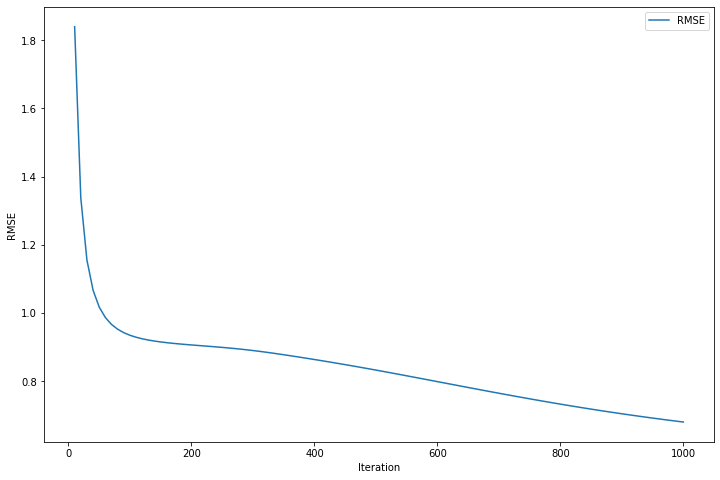

CPU times: user 12min 25s, sys: 16min 36s, total: 29min 2s
Wall time: 5min 43s


In [22]:
%%time
model_svd = SVD(64, iterations=1000, lr=1e-4, verbose=True, weight_decay=1e-2)
model_svd.fit(user_item_exp)  

timestamp = datetime.now()
model_svd.logger.save(f"log.{timestamp.date()}_{timestamp.time()}.csv")
model_svd.logger.plot("iter", "rmse", label="RMSE", x_label="Iteration", y_label="RMSE")

In [23]:
# test(model_svd)

Iter:   10 | RMSE: 2.23125E+00
Iter:   20 | RMSE: 2.14656E+00
Iter:   30 | RMSE: 2.11906E+00
Iter:   40 | RMSE: 2.11266E+00
Iter:   50 | RMSE: 2.10913E+00


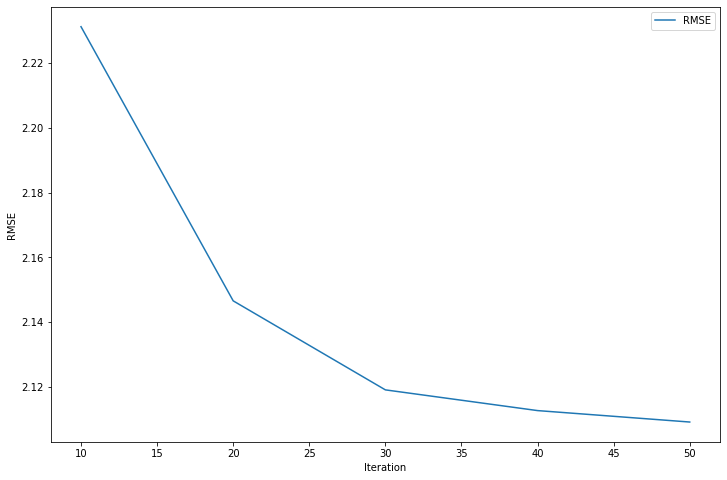

CPU times: user 10min 34s, sys: 5.73 s, total: 10min 40s
Wall time: 10min 41s


In [24]:
%%time
model_svds = SVDS(64, iterations=50, lr=1e-2, verbose=True, weight_decay=1e-2, save_every=10)

model_svds.fit(user_item_exp)

timestamp = datetime.now()
model_svds.logger.save(f"log.{timestamp.date()}_{timestamp.time()}.csv")
model_svds.logger.plot("iter", "rmse", label="RMSE", x_label="Iteration", y_label="RMSE")

In [25]:
# test(model_svds)

### Задание 2. Не использую готовые решения, реализовать матричное разложение используя ALS на implicit данных

In [26]:
from factorization import ALS

Iter:    1 | RMSE: 7.25811E-01
Iter:    2 | RMSE: 6.55017E-01
Iter:    3 | RMSE: 6.45272E-01
Iter:    4 | RMSE: 6.42080E-01
Iter:    5 | RMSE: 6.40613E-01
Iter:    6 | RMSE: 6.39803E-01
Iter:    7 | RMSE: 6.39311E-01
Iter:    8 | RMSE: 6.38994E-01
Iter:    9 | RMSE: 6.38782E-01
Iter:   10 | RMSE: 6.38635E-01


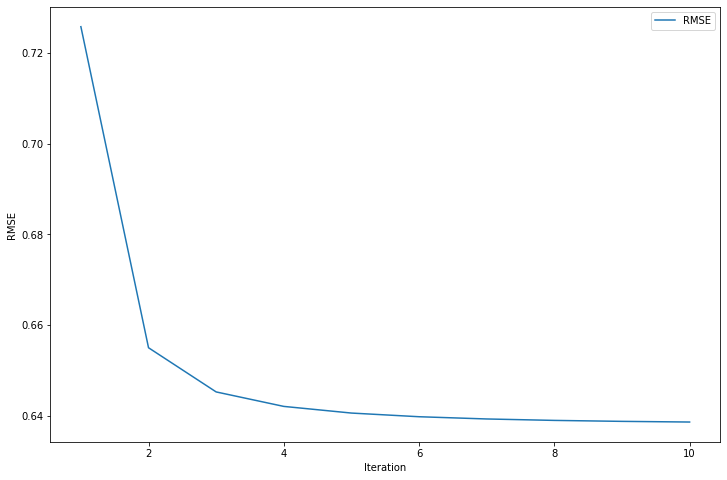

CPU times: user 20min 41s, sys: 24min 51s, total: 45min 33s
Wall time: 6min 52s


In [27]:
%%time
model_als = ALS(64, 10, 1e-5, 1e-5, True)

model_als.fit(user_item_csr)

timestamp = datetime.now()
model_als.logger.save(f"log.{timestamp.date()}_{timestamp.time()}.csv")
model_als.logger.plot("iter", "rmse", label="RMSE", x_label="Iteration", y_label="RMSE")

In [28]:
# test(model_als)

### Задание 3. Не использую готовые решения, реализовать матричное разложение BPR на implicit данных

In [29]:
from factorization import BPR

Iter:    500 | AUC: 0.91199 | AUC2: 0.79933
Iter:   1000 | AUC: 0.94844 | AUC2: 0.88768
Iter:   1500 | AUC: 0.95828 | AUC2: 0.88847
Iter:   2000 | AUC: 0.96311 | AUC2: 0.92172
Iter:   2500 | AUC: 0.96585 | AUC2: 0.94717
Iter:   3000 | AUC: 0.96738 | AUC2: 0.85586
Iter:   3500 | AUC: 0.96956 | AUC2: 0.93889
Iter:   4000 | AUC: 0.97038 | AUC2: 0.87874
Iter:   4500 | AUC: 0.97079 | AUC2: 0.92270
Iter:   5000 | AUC: 0.97189 | AUC2: 0.93687
Iter:   5500 | AUC: 0.97218 | AUC2: 0.93678
Iter:   6000 | AUC: 0.97275 | AUC2: 0.92050
Iter:   6500 | AUC: 0.97299 | AUC2: 0.90142
Iter:   7000 | AUC: 0.97336 | AUC2: 0.92115
Iter:   7500 | AUC: 0.97357 | AUC2: 0.89037
Iter:   8000 | AUC: 0.97318 | AUC2: 0.95924
Iter:   8500 | AUC: 0.97417 | AUC2: 0.94033
Iter:   9000 | AUC: 0.97396 | AUC2: 0.89985
Iter:   9500 | AUC: 0.97448 | AUC2: 0.91312
Iter:  10000 | AUC: 0.97411 | AUC2: 0.92426


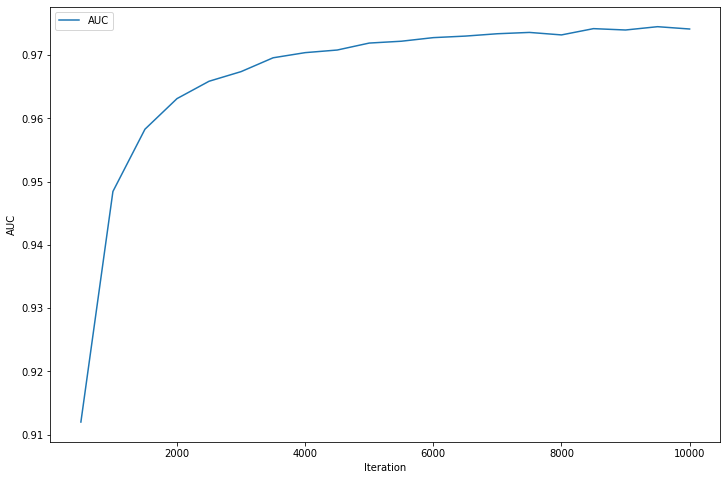

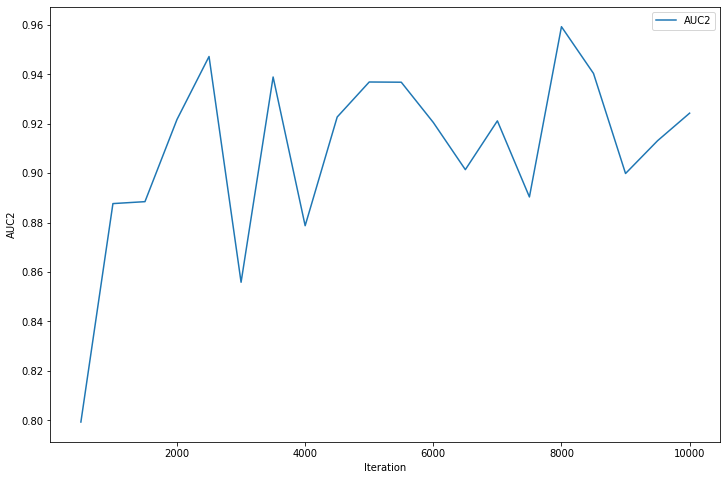

CPU times: user 24min 22s, sys: 26min 4s, total: 50min 27s
Wall time: 20min 6s


In [30]:
%%time
model_bpr = BPR(64, int(1e4), 1e-1, 1e-2, True, save_every=500)

model_bpr.fit(user_item_csr, batch_size=3000)

timestamp = datetime.now()
model_bpr.logger.save(f"log.{timestamp.date()}_{timestamp.time()}.csv")
model_bpr.logger.plot("iter", "AUC", label="AUC", x_label="Iteration", y_label="AUC")
model_bpr.logger.plot("iter", "AUC2", label="AUC2", x_label="Iteration", y_label="AUC2")

In [31]:
# test(model_bpr)

### Задание 4. Не использую готовые решения, реализовать матричное разложение WARP на implicit данных

In [32]:
test(model_svd)

Similar to Toy Story (1995) (Animation|Children's|Comedy):
1) Toy Story 2 (1999) (Animation|Children's|Comedy)
2) Bug's Life, A (1998) (Animation|Children's|Comedy)
3) Crimson Pirate, The (1952) (Adventure|Comedy|Sci-Fi)
4) Iron Giant, The (1999) (Animation|Children's)
5) American Tail: Fievel Goes West, An (1991) (Animation|Children's|Comedy)
6) Anne Frank Remembered (1995) (Documentary)
7) Shall We Dance? (Shall We Dansu?) (1996) (Comedy)
8) Pharaoh's Army (1995) (War)
9) Dumbo (1941) (Animation|Children's|Musical)
10) Hostile Intentions (1994) (Action|Drama|Thriller)

Recommended movies for user 4:
1) Godfather, The (1972) (Action|Crime|Drama)
2) To Kill a Mockingbird (1962) (Drama)
3) Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954) (Action|Drama)
4) Sanjuro (1962) (Action|Adventure)
5) Lawrence of Arabia (1962) (Adventure|War)
6) Fargo (1996) (Crime|Drama|Thriller)
7) One Flew Over the Cuckoo's Nest (1975) (Drama)
8) For All Mankind (1989) (Documentary)
9) Citiz

In [33]:
test(model_svds)

Similar to Toy Story (1995) (Animation|Children's|Comedy):
1) Toy Story 2 (1999) (Animation|Children's|Comedy)
2) Bug's Life, A (1998) (Animation|Children's|Comedy)
3) One Man's Hero (1999) (Drama|War)
4) Marcello Mastroianni: I Remember Yes, I Remember (1997) (Documentary)
5) Legal Deceit (1997) (Thriller)
6) Breaks, The (1999) (Drama)
7) Twisted (1996) (Comedy|Drama)
8) Big (1988) (Comedy|Fantasy)
9) Aladdin (1992) (Animation|Children's|Comedy|Musical)
10) Wooden Man's Bride, The (Wu Kui) (1994) (Drama)

Recommended movies for user 4:
1) Breaking the Waves (1996) (Drama)
2) Lifeboat (1944) (Drama|Thriller|War)
3) Seven Beauties (Pasqualino Settebellezze) (1976) (Comedy|Drama)
4) Buena Vista Social Club (1999) (Documentary)
5) Garden of Finzi-Contini, The (Giardino dei Finzi-Contini, Il) (1970) (Drama)
6) Inherit the Wind (1960) (Drama)
7) Men With Guns (1997) (Action|Drama)
8) River Runs Through It, A (1992) (Drama)
9) Return of the Pink Panther, The (1974) (Comedy)
10) Hamlet (1948)

In [34]:
test(model_als)

Similar to Toy Story (1995) (Animation|Children's|Comedy):
1) Toy Story 2 (1999) (Animation|Children's|Comedy)
2) Babe (1995) (Children's|Comedy|Drama)
3) Bug's Life, A (1998) (Animation|Children's|Comedy)
4) Babe: Pig in the City (1998) (Children's|Comedy)
5) Pleasantville (1998) (Comedy)
6) Aladdin (1992) (Animation|Children's|Comedy|Musical)
7) Lion King, The (1994) (Animation|Children's|Musical)
8) Hercules (1997) (Adventure|Animation|Children's|Comedy|Musical)
9) Mulan (1998) (Animation|Children's)
10) Stuart Little (1999) (Children's|Comedy)

Recommended movies for user 4:
1) Terminator 2: Judgment Day (1991) (Action|Sci-Fi|Thriller)
2) Indiana Jones and the Last Crusade (1989) (Action|Adventure)
3) Star Wars: Episode V - The Empire Strikes Back (1980) (Action|Adventure|Drama|Sci-Fi|War)
4) Butch Cassidy and the Sundance Kid (1969) (Action|Comedy|Western)
5) Close Encounters of the Third Kind (1977) (Drama|Sci-Fi)
6) Fugitive, The (1993) (Action|Thriller)
7) Matrix, The (1999) (A

In [35]:
test(model_bpr)

Similar to Toy Story (1995) (Animation|Children's|Comedy):
1) Toy Story 2 (1999) (Animation|Children's|Comedy)
2) Alley Cats, The (1968) (Drama)
3) First Kid (1996) (Children's|Comedy)
4) Mighty Morphin Power Rangers: The Movie (1995) (Action|Children's)
5) Fun and Fancy Free (1947) (Animation|Children's|Musical)
6) Land Before Time III: The Time of the Great Giving (1995) (Animation|Children's)
7) Big Green, The (1995) (Children's|Comedy)
8) Cats Don't Dance (1997) (Animation|Children's|Musical)
9) Fluke (1995) (Children's|Drama)
10) Thumbelina (1994) (Animation|Children's)

Recommended movies for user 4:
1) Ben-Hur (1959) (Action|Adventure|Drama)
2) Godfather: Part II, The (1974) (Action|Crime|Drama)
3) Exorcist, The (1973) (Horror)
4) Full Metal Jacket (1987) (Action|Drama|War)
5) Aliens (1986) (Action|Sci-Fi|Thriller|War)
6) Godfather, The (1972) (Action|Crime|Drama)
7) Predator (1987) (Action|Sci-Fi|Thriller)
8) Butch Cassidy and the Sundance Kid (1969) (Action|Comedy|Western)
9) 